# Forecasting Model and Training.
<a id='top_cell'></a>
Following the Preprocessing and filtering used on (Neighbors and districts pre-processing.ipynb), we make a forecasting model for spatio temporal data, using Tensoflow + Keras libraries and trained

This Notebook was originally on Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
import seaborn as sns
import pandas as pd
from sklearn.utils import check_array
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import math
import statistics
from datetime import time
from keras.regularizers import l2
import tensorflow as tf
from pickle import dump, load
from statistics import mean
from __future__ import print_function
import os
import copy
import warnings
import graphviz
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
import multiprocessing
import pickle
import sklearn
from datetime import time
from datetime import datetime
# Advanced plotting functionality with seaborn
import seaborn as sns
sns.set(style="whitegrid")  # can set style depending on how you'd like it to look

##Dataframes

In [ ]:
df= pd.read_csv('/content/drive/MyDrive/DS4A/dataframes/Recurso_Barrios_Comunas_Cor_6.csv') # In case of Resource dataset
#df= pd.read_csv('/content/drive/MyDrive/DS4A/dataframes/Crimen_Barrios_Comunas_Cor_7.csv') # In case of Crimen dataset
df.head()

,fecha_hecho,cantidad,latitud,longitud,sexo,edad,estado_civil,grupo_actor,actividad_delictiva,parentesco,...,modelo,color,permiso,unidad_medida,fecha_ingestion,Nbase,precipitacion,hora,fecha,dia
0,2004-01-02 07:30:00-05:00,1.0,6.253681,-75.565748,mujer,13.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2022-03-06t04:06:16.000-05:00,aprehension,NaN,07:30:00,2004-01-02,viernes
1,2004-01-03 13:30:00-05:00,1.0,6.254496,-75.569123,hombre,13.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2022-03-06t04:06:16.000-05:00,aprehension,NaN,13:30:00,2004-01-03,sabado
2,2004-01-04 16:30:00-05:00,1.0,6.229947,-75.574464,hombre,13.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2022-03-06t04:06:16.000-05:00,aprehension,NaN,16:30:00,2004-01-04,domingo
3,2004-01-04 16:30:00-05:00,1.0,6.229947,-75.574464,hombre,12.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2022-03-06t04:06:16.000-05:00,aprehension,NaN,16:30:00,2004-01-04,domingo
4,2004-01-05 15:00:00-05:00,1.0,6.254431,-75.566951,hombre,12.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2022-03-06t04:06:16.000-05:00,aprehension,NaN,15:00:00,2004-01-05,lunes


We Filter the dataframes in to cases with the word 'captura' for capture cases on the resource dataset and with the word 'hurto' for theft cases on the crime dataset

In [ ]:
df=df[df.Nbase.str.contains('captura', na=False)]
#df.tail()
#df=df[df.Nbase.str.contains('hurto', na=False)]

In [ ]:
df['Nbase'].unique()

array(['captura'], dtype=object)

We drop the columns that are not going to be used iin order to easily load the dataset in further cells

In [ ]:
df = df.drop(columns=['cantidad','latitud','longitud','actividad_delictiva','parentesco','ocupacion','discapacidad','grupo_especial',
                      'medio_transporte','nivel_academico','testigo','modalidad','caracterizacion','conducta_especial','articulo_penal',
                      'categoria_penal','codigo_barrio','lugar','sede_receptora','bien','categoria_bien','modelo','color','permiso',
                      'unidad_medida','fecha_ingestion','fecha_hecho','hora'])

We turn date column into datetime format

In [ ]:
df['fecha'] = pd.to_datetime(df['fecha'])

We fix some error that is not solve for District column on last notebook

In [ ]:
df['codigo_comuna'] = df['codigo_comuna'].str.split(".", 1, expand=True)[0]

In [ ]:
comunas = []
for i in df['codigo_comuna']:
  if pd.isna(i):
    comunas.append(i)
  else:
    if i.isnumeric():
      if int(i) <= 16:
        comunas.append('Comuna '+i)
      else:
        comunas.append('Corregimiento '+i)
    else:
      comunas.append(i)
df['codigo_comuna'] = comunas

For some experiments we group the data from other columns rather than location but is nessesary to make the least posible groups son in this part we group the values of some columns into more condensed groups.

In [ ]:
df['estado_civil']= df['estado_civil'].fillna('none')
df['estado_civil'].loc[(df['estado_civil'] == 'soltero') | (df['estado_civil'] == 'none') | (df['estado_civil'] == 'divorciado') | (df['estado_civil'] == 'viudo')] = 'Sin Pareja'
df['estado_civil'].loc[(df['estado_civil'] == 'casado') | (df['estado_civil'] == 'union marital de hecho')] = 'Con Pareja'

df['grupo_actor']= df['grupo_actor'].fillna('none')
df['grupo_actor'].loc[(df['grupo_actor'] == 'delincuencia') | (df['grupo_actor'] == 'guerrilla') | (df['grupo_actor'] == 'bacrim') | (df['grupo_actor'] == 'paramilitar') | (df['grupo_actor'] == 'grupo armado') | (df['grupo_actor'] == 'f. publica')] = 'Con Grupo'
df['grupo_actor'].loc[(df['grupo_actor'] == 'none') | (df['grupo_actor'] == 'ninguno')] = 'Sin Grupo'

df['arma_medio']= df['arma_medio'].fillna('none')
df['arma_medio'].loc[(df['arma_medio'] == 'no') | (df['arma_medio'] == 'none') ] = 'Sin Arma'
df['arma_medio'].loc[(df['arma_medio'] == 'arma de fuego') | (df['arma_medio'] == 'otro explosivo')] = 'Arma de Fuego / Explosivo'
df['arma_medio'].loc[(df['arma_medio'] == 'escopolamina') | (df['arma_medio'] == 'toxico o quimico') ] = 'Arma Quimica'
df['arma_medio'].loc[(df['arma_medio'] == 'arma cortopunzante') | (df['arma_medio'] == 'llave maestra') | (df['arma_medio'] == 'objeto contundente') | (df['arma_medio'] == 'palanca') | (df['arma_medio'] == 'perro') | (df['arma_medio'] == 'vehiculo')] = 'Objeto contundente o cortopunzante'


Then we make some dataframes that count or have the mean of the diferent values we group before and for the Neighbors and Districts for each date

In [ ]:
## This part is used when the Crime dataset is used
"""Sexo = df.groupby(['fecha','sexo']).count()['Unnamed: 0'].reset_index().pivot(index='fecha', columns='sexo', values='Unnamed: 0').fillna(0)
Edad = df.groupby(['fecha','sexo']).sum()['edad'].reset_index().pivot(index='fecha', columns='sexo', values='edad').div(Sexo).fillna(0)
Estado_Civil = df.groupby(['fecha','estado_civil']).count()['Unnamed: 0'].reset_index().pivot(index='fecha', columns='estado_civil', values='Unnamed: 0').fillna(0)
Grupo_Actor = df.groupby(['fecha','grupo_actor']).count()['Unnamed: 0'].reset_index().pivot(index='fecha', columns='grupo_actor', values='Unnamed: 0').fillna(0)
Arma = df.groupby(['fecha','arma_medio']).count()['Unnamed: 0'].reset_index().pivot(index='fecha', columns='arma_medio', values='Unnamed: 0').fillna(0)
Crimen = df.groupby(['fecha','Nbase']).count()['Unnamed: 0'].reset_index().pivot(index='fecha', columns='Nbase', values='Unnamed: 0').fillna(0)
Comuna = df.groupby(['fecha','codigo_comuna']).count()['Unnamed: 0'].reset_index().pivot(index='fecha', columns='codigo_comuna', values='Unnamed: 0').fillna(0)
Barrio = df.groupby(['fecha','nombre_barrio']).count()['Unnamed: 0'].reset_index().pivot(index='fecha', columns='nombre_barrio', values='Unnamed: 0').fillna(0)"""


## This part is used when the resource dataset is used
Sexo = df.groupby(['fecha','sexo']).count()['Nbase'].reset_index().pivot(index='fecha', columns='sexo', values='Nbase').fillna(0)
Edad = df.groupby(['fecha','sexo']).sum()['edad'].reset_index().pivot(index='fecha', columns='sexo', values='edad').div(Sexo).fillna(0)
Estado_Civil = df.groupby(['fecha','estado_civil']).count()['Nbase'].reset_index().pivot(index='fecha', columns='estado_civil', values='Nbase').fillna(0)
Grupo_Actor = df.groupby(['fecha','grupo_actor']).count()['Nbase'].reset_index().pivot(index='fecha', columns='grupo_actor', values='Nbase').fillna(0)
Arma = df.groupby(['fecha','arma_medio']).count()['Nbase'].reset_index().pivot(index='fecha', columns='arma_medio', values='Nbase').fillna(0)
Comuna = df.groupby(['fecha','codigo_comuna']).count()['Nbase'].reset_index().pivot(index='fecha', columns='codigo_comuna', values='Nbase').fillna(0)
Barrio = df.groupby(['fecha','nombre_barrio']).count()['Nbase'].reset_index().pivot(index='fecha', columns='nombre_barrio', values='Nbase').fillna(0)

In [ ]:
Comuna

codigo_comuna,Comuna 1,Comuna 10,Comuna 11,Comuna 12,Comuna 13,Comuna 14,Comuna 15,Comuna 16,Comuna 2,Comuna 3,...,Comuna 5,Comuna 6,Comuna 7,Comuna 8,Comuna 9,Corregimiento 50,Corregimiento 60,Corregimiento 70,Corregimiento 80,Corregimiento 90
fecha,,,,,,,,,,,,,,,,,,,,,
2004-01-01,1.0,10.0,2.0,0.0,3.0,3.0,2.0,4.0,3.0,1.0,...,5.0,7.0,5.0,2.0,1.0,0.0,1.0,1.0,5.0,0.0
2004-01-02,0.0,18.0,5.0,1.0,1.0,3.0,6.0,6.0,0.0,5.0,...,3.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2004-01-03,0.0,28.0,4.0,0.0,0.0,3.0,5.0,4.0,3.0,1.0,...,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2004-01-04,7.0,20.0,2.0,3.0,1.0,1.0,0.0,5.0,3.0,2.0,...,1.0,2.0,5.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0
2004-01-05,2.0,17.0,5.0,1.0,0.0,1.0,5.0,4.0,4.0,3.0,...,5.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-26,7.0,1.0,5.0,1.0,0.0,0.0,0.0,2.0,4.0,1.0,...,2.0,2.0,3.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
2021-09-27,6.0,8.0,1.0,0.0,0.0,1.0,6.0,0.0,1.0,2.0,...,3.0,6.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0
2021-09-28,2.0,12.0,0.0,0.0,1.0,1.0,3.0,2.0,4.0,2.0,...,3.0,1.0,0.0,9.0,2.0,0.0,0.0,0.0,0.0,0.0


We drop 'sin nombre' from the neighbors beacuse it is a null value

In [ ]:
Barrio = Barrio.drop(columns=['Sin Nombre'])

Then we need to concatenated the dataframes we generate before, on the next cell there are diferente experiments developed, at the end the best values are the ones that only uses Neihgbor dataframe or Districs Dataframe for predict Neighbors or Districs next day cases respectively.

In [ ]:
#result = pd.concat([Barrio, Sexo, Edad, Estado_Civil, Grupo_Actor, Arma, Crimen, Comuna], axis=1)
#result = pd.concat([Barrio, Sexo, Edad, Estado_Civil, Grupo_Actor, Arma, Comuna], axis=1)
#result = Barrio
result = Comuna
#result = pd.concat([Barrio, Arma, Crimen], axis=1)
#result = pd.concat([Barrio, Sexo, Edad, Estado_Civil], axis=1)
#result = pd.concat([Barrio, Sexo, Edad, Estado_Civil, Grupo_Actor, Arma], axis=1)
result.head()

codigo_comuna,Comuna 1,Comuna 10,Comuna 11,Comuna 12,Comuna 13,Comuna 14,Comuna 15,Comuna 16,Comuna 2,Comuna 3,...,Comuna 5,Comuna 6,Comuna 7,Comuna 8,Comuna 9,Corregimiento 50,Corregimiento 60,Corregimiento 70,Corregimiento 80,Corregimiento 90
fecha,,,,,,,,,,,,,,,,,,,,,
2004-01-01,1.0,10.0,2.0,0.0,3.0,3.0,2.0,4.0,3.0,1.0,...,5.0,7.0,5.0,2.0,1.0,0.0,1.0,1.0,5.0,0.0
2004-01-02,0.0,18.0,5.0,1.0,1.0,3.0,6.0,6.0,0.0,5.0,...,3.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2004-01-03,0.0,28.0,4.0,0.0,0.0,3.0,5.0,4.0,3.0,1.0,...,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2004-01-04,7.0,20.0,2.0,3.0,1.0,1.0,0.0,5.0,3.0,2.0,...,1.0,2.0,5.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0
2004-01-05,2.0,17.0,5.0,1.0,0.0,1.0,5.0,4.0,4.0,3.0,...,5.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0


For avoid some noise of old dates that don't represent the trend of the actual data we cut the dataframe and leave dates from 2015 to the last date that is 2021/09/30

In [ ]:
result = result.drop(result[result.index < '2015-01-01'].index)

In [ ]:
result.head()

codigo_comuna,Comuna 1,Comuna 10,Comuna 11,Comuna 12,Comuna 13,Comuna 14,Comuna 15,Comuna 16,Comuna 2,Comuna 3,...,Comuna 5,Comuna 6,Comuna 7,Comuna 8,Comuna 9,Corregimiento 50,Corregimiento 60,Corregimiento 70,Corregimiento 80,Corregimiento 90
fecha,,,,,,,,,,,,,,,,,,,,,
2015-01-01,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-02,0.0,3.0,0.0,3.0,0.0,0.0,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-03,0.0,4.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0,1.0,...,1.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0
2015-01-04,3.0,5.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0,2.0,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
2015-01-05,1.0,8.0,2.0,0.0,0.0,2.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0,0.0,0.0


We add information regarding to the time on 3 columns one for year, other for month and the last one for day

In [ ]:
df = result.copy()

In [ ]:
df['Fecha'] = pd.to_datetime(df.index)
df.head()

codigo_comuna,Comuna 1,Comuna 10,Comuna 11,Comuna 12,Comuna 13,Comuna 14,Comuna 15,Comuna 16,Comuna 2,Comuna 3,...,Comuna 6,Comuna 7,Comuna 8,Comuna 9,Corregimiento 50,Corregimiento 60,Corregimiento 70,Corregimiento 80,Corregimiento 90,Fecha
fecha,,,,,,,,,,,,,,,,,,,,,
2015-01-01,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-01-01
2015-01-02,0.0,3.0,0.0,3.0,0.0,0.0,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-01-02
2015-01-03,0.0,4.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0,1.0,...,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,2015-01-03
2015-01-04,3.0,5.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0,2.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,2015-01-04
2015-01-05,1.0,8.0,2.0,0.0,0.0,2.0,0.0,1.0,1.0,1.0,...,0.0,0.0,2.0,1.0,0.0,0.0,2.0,0.0,0.0,2015-01-05


In [ ]:
df = df.reset_index(drop=True)
df.head()

codigo_comuna,Comuna 1,Comuna 10,Comuna 11,Comuna 12,Comuna 13,Comuna 14,Comuna 15,Comuna 16,Comuna 2,Comuna 3,...,Comuna 6,Comuna 7,Comuna 8,Comuna 9,Corregimiento 50,Corregimiento 60,Corregimiento 70,Corregimiento 80,Corregimiento 90,Fecha
0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-01-01
1,0.0,3.0,0.0,3.0,0.0,0.0,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-01-02
2,0.0,4.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0,1.0,...,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,2015-01-03
3,3.0,5.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0,2.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,2015-01-04
4,1.0,8.0,2.0,0.0,0.0,2.0,0.0,1.0,1.0,1.0,...,0.0,0.0,2.0,1.0,0.0,0.0,2.0,0.0,0.0,2015-01-05


In [ ]:
#df['Year'] = df['Fecha'].dt.year
#df['Month'] = df['Fecha'].dt.month
#df['Day'] = df['Fecha'].dt.day

We validate if by change we generate some null values on the dataset on the group by operation and save the results on a csv for a further generation on the data for the power bi dashboard

In [ ]:
for i in df.columns.values:
  if df[i].isnull().values.any():
    print(i)

In [ ]:
df = df.fillna(0)

In [ ]:
df.isnull().values.any()

False

In [ ]:
df.to_csv('/content/drive/MyDrive/DS4A/dataframes/Data_Predict_Captura_Comunas.csv')
#df.to_csv('/content/drive/MyDrive/DS4A/dataframes/Data_Predict_Hurto_Comunas.csv')
#df.to_csv('/content/drive/MyDrive/DS4A/dataframes/Data_Predict_Captura_Barrios.csv')
#df.to_csv('/content/drive/MyDrive/DS4A/dataframes/Data_Predict_Hurto_Barrios.csv')

##Data special Prep for the model
For the model there are 4 steps that are essential for its correctly funtion


1.   Delete the data that is not numeric such as the date column
2.   Scale and fix the dimention of the dataset when using LSTM or GRU layers 
3.   Generate X and Y sets by shifting the dataset in order to predict next day
4.   Divide the X and Y into train and test sets



In [ ]:
df=df.drop(columns=['Fecha'])

In [ ]:
#Scale data between 0,1 for LSTM/GRU
MMS = MinMaxScaler(feature_range=(0, 1))
df_scale = pd.DataFrame(MMS.fit_transform(df.values), columns=df.columns)


#  Remember to shift the data so we are predicting one time step future
X = df_scale.iloc[:-1:]
#y = df_scale.iloc[1:,:-3] #locationIDs Solo Barrios Hurtos
y = df_scale.iloc[1:,:] #locationIDs Solo Barrios sin fecha Hurtos
#y = df_scale.iloc[1:,:-16] #locationIDs Barrios, crimen, arma Hurtos
#y = df_scale.iloc[1:,:-9] #locationIDs Barrio, Sexo, Edad, Estado_Civil  Hurtos
#y = df_scale.iloc[1:,:-24] #locationIDs Barrio, Comunas  Hurtos
#y = df_scale.iloc[1:,:-14] #locationIDs Barrio, Sexo, Edad, Estado_Civil, Grupo_Actor, Arma  Hurtos
#y = df_scale.iloc[1:,:-49] #locationIDs Barrios Hurtos
#y = df_scale.iloc[1:,-24:-3] #locationIDs Comunas Hurtos y Captura
#y = df_scale.iloc[1:,:-32] #locationIDs Barrios Captura

# Train-Test-Split-90/10
X_train, X_test = X[:int(round(len(X)*0.8, 0))], X[int(round(len(X)*0.8, 0)):]
y_train, y_test = y[:int(round(len(y)*0.8, 0))], y[int(round(len(y)*0.8, 0)):]

#Reshape for LSTM/GRU layers
Xtr = X_train.values.reshape((1, X_train.shape[0], X_train.shape[1]))
#Xtr = X_train.reshape((X_train.shape[0],look_back, X_train.shape[2]))
ytr = y_train.values.reshape((1,y_train.shape[0], y_train.shape[1]))
Xte = X_test.values.reshape((1, X_test.shape[0], X_test.shape[1]))
#Xte = X_test.reshape(( X_test.shape[0],look_back, X_test.shape[2]))
yte = y_test.values.reshape((1,y_test.shape[0], y_test.shape[1]))

#Check data validity
print(len(X_train) + len(X_test), len(y_train) + len(y_test))

2462 2462


In [ ]:
y_train.shape

(1970, 21)

In [ ]:
X_train.shape

(1970, 21)

## Metrics

For this model we use an $R^2$ metric that is kind of a similarity percentage between the Real values and Predict ones, but we make a custom one instead of using the Sklearn or Keras preset ones beacuse it express better the similarity percentage

In [ ]:
import keras.backend as K
#K._BACKEND == 'tensorflow'

def custom_r2(y_true, y_pred):
    baseline = K.sum((y_true - K.mean(y_true))**2)
    model_fit = K.sum((y_true - y_pred)**2)
    return 1. - model_fit/baseline

#Model 
For the model we use Keras library and use differenet type of layers

In [ ]:
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, Dropout, GRU, TimeDistributed, Input, merge, Activation
from keras.layers import Reshape
from tensorflow.keras.optimizers import Adamax

There are two functions, the first to save the model once it finish training process and the second one plots the evolution of $R^2$ and loss function over the epochs

In [ ]:
def save_unit_weights():
    '''
    Saves weights of previously run neural_network.

    Parameters
    ----------
    '''
    file_name = str(datetime.now()).replace(':', '_').replace(' ','_')[:19]
    model.save_weights('/content/drive/MyDrive/DS4A/logs/'+file_name+'.h5', overwrite=True)
    print('Saved ||', str(datetime.now()))
    
    
def plot_neural_net_results(history, limit_r2=0, save_results=0):
    '''
    Plots results of neural network.

    Parameters
    ----------
    '''
    results = pd.DataFrame(history.history)
    #results = pd.read_csv('/Users/austinwhaley/Desktop/DSI-SF-4-austinmwhaley/other_datasets/uber_results_mse_attn_1000').drop('Unnamed: 0', 1)

    # SUMMARY RESULTS
    print('---MAX RESULTS--- \n', results[['custom_r2','val_custom_r2']].iloc[:].max(), '\n')
    print('---TAIL RESULTS--- \n', results[['custom_r2','val_custom_r2']].iloc[-1:], '\n')

    # Build figure
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,4.5))

    # Assign Axis Plots
    ax0.plot(results[['custom_r2', 'val_custom_r2']].iloc[:])
    ax1.plot(results[['loss', 'val_loss']].iloc[:])

    # Add horizontal and vertical line for max
    ax0.axhline(results['val_custom_r2'].max(), color='red', lw=0.5)
    ax0.axvline(results['val_custom_r2'].idxmax(), color='red', lw=0.5)

    #Set axis limits
    if limit_r2 == 1:
        ax0.set_ylim(bottom=0.5, top=0.6)

    # Rename axis titles
    ax0.set_title('r2', fontsize=15)
    ax1.set_title('loss', fontsize=15)

    #ax0.legend(loc='lower right')

    # Show plots
    plt.show()

    if save_results == 1:
        file_name = str(datetime.now()).replace(':', '_').replace(' ','_')[:19]
        results.to_csv('/content/drive/MyDrive/DS4A/results_'+ file_name + '.csv')

This function contained the model and only change some input parameters as input and output size beacuse the dataframe is larger if it is of Neighbors than with Districts, the learning rate of the optimization fuction and the loss function also the dropout rate

In [ ]:
def build_model_2(n_features, dropout, n_outputs, compile_model=1, load_weights=0, loss='mse', lr=0.01):
    '''
    Builds a n-Layer neural_network 
    
    Parmaters
    ---------
    
    '''
    model = Sequential()

    #DENSE - INPUT
    model.add(Conv1D(filters=2048, kernel_size=2, activation='relu', input_shape=(None, n_features),padding="same"))
    model.add(Dropout(dropout))
    model.add(GRU(4096, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(TimeDistributed(Dense(1000, activation='relu')))
    model.add(TimeDistributed(Dense(n_outputs, activation='relu')))

    if compile_model == 1:
        model.compile(loss=loss, optimizer=Adamax(lr=lr), metrics=[custom_r2])

    if load_weights == 1:
        model.load_weights('/content/drive/MyDrive/DS4A/logs/'+file_name+'.h5')
        
    return model

We compile the model, and after some experiments the best results are found with the input parameters shown below

In [ ]:
#1 - Build Model
model = build_model_2(n_features=Xtr.shape[2], dropout=0.1, n_outputs=ytr.shape[2], compile_model=1, load_weights=0, lr=0.0001, loss = 'msle')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 2048)        88064     
                                                                 
 dropout_2 (Dropout)         (None, None, 2048)        0         
                                                                 
 gru_1 (GRU)                 (None, None, 4096)        75522048  
                                                                 
 dropout_3 (Dropout)         (None, None, 4096)        0         
                                                                 
 time_distributed_2 (TimeDis  (None, None, 1000)       4097000   
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, None, 21)         21021     
 tributed)                                            

##Model Training
We train the model and use checkpoint callback to save the model at is best test $R^2$ and train the models for 2000 epochs on Neighbors and 1000 for Districts

In [ ]:
save_weights=1
verbose=1
n_epochs=1000


model_name='Model_1_Medellin_ComunaSinFecha_Captura_2015'
log_dir="/content/drive/MyDrive/DS4A/logs/"
filepath = log_dir+model_name+".h5"
#early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=15)
#reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=20)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_custom_r2', save_best_only=True, mode='max')
history = model.fit(Xtr, ytr, validation_data=(Xte, yte), verbose=verbose, epochs=n_epochs, shuffle=False,callbacks=[checkpoint])
#history = model10.fit(X_train,y_train,validation_data=(X_test, y_test),epochs=200, verbose=1,callbacks=[checkpoint,early_stopping,reduce_lr])
if save_weights == 1:
    save_unit_weights()

Epoch 1/1000
1/1 [==============================] - 8s 8s/step - loss: 0.0221 - custom_r2: -0.7498 - val_loss: 0.0072 - val_custom_r2: -0.0941
Epoch 2/1000
1/1 [==============================] - 6s 6s/step - loss: 0.0159 - custom_r2: -0.3019 - val_loss: 0.0062 - val_custom_r2: 0.0578
Epoch 3/1000
1/1 [==============================] - 6s 6s/step - loss: 0.0127 - custom_r2: -0.0494 - val_loss: 0.0058 - val_custom_r2: 0.1125
Epoch 4/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0109 - custom_r2: 0.0932 - val_loss: 0.0059 - val_custom_r2: 0.1059
Epoch 5/1000
1/1 [==============================] - 2s 2s/step - loss: 0.0103 - custom_r2: 0.1482 - val_loss: 0.0060 - val_custom_r2: 0.1003
Epoch 6/1000
1/1 [==============================] - 6s 6s/step - loss: 0.0098 - custom_r2: 0.1892 - val_loss: 0.0059 - val_custom_r2: 0.1195
Epoch 7/1000
1/1 [==============================] - 6s 6s/step - loss: 0.0093 - custom_r2: 0.2291 - val_loss: 0.0056 - val_custom_r2: 0.1459
Epoch 8/1

---MAX RESULTS--- 
 custom_r2        0.942951
val_custom_r2    0.846996
dtype: float64 

---TAIL RESULTS--- 
       custom_r2  val_custom_r2
1999   0.942695       0.846533 



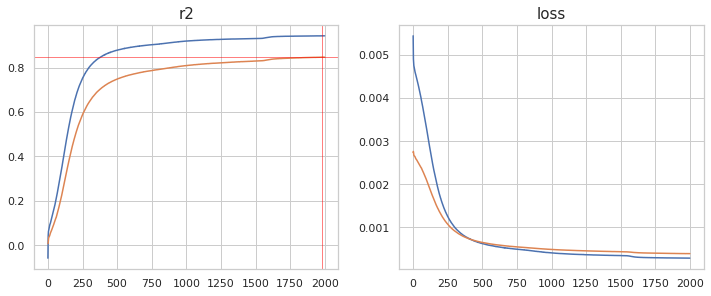

In [ ]:
plot_neural_net_results(history, save_results=1)

## Test Examples

In [ ]:
pred = model.predict(Xte)

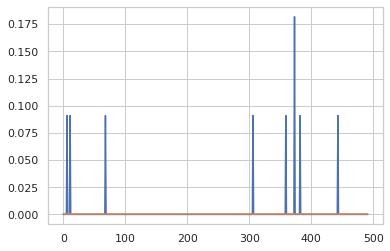

In [ ]:
plt.plot(yte[:,:,1].reshape(yte.shape[1]))
plt.plot(pred[:,:,1].reshape(yte.shape[1]))

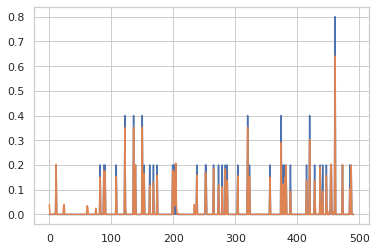

In [ ]:
plt.plot(yte[:,:,2].reshape(yte.shape[1]))
plt.plot(pred[:,:,2].reshape(yte.shape[1]))

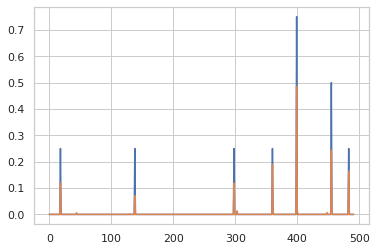

In [ ]:
plt.plot(yte[:,:,3].reshape(yte.shape[1]))
plt.plot(pred[:,:,3].reshape(yte.shape[1]))

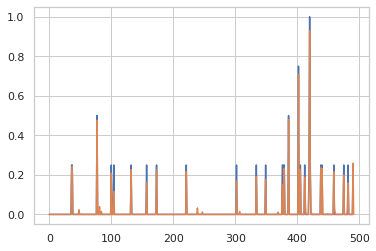

In [ ]:
plt.plot(yte[:,:,9].reshape(yte.shape[1]))
plt.plot(pred[:,:,9].reshape(yte.shape[1]))

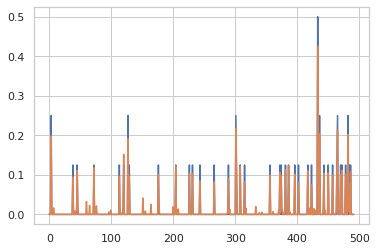

In [ ]:
plt.plot(yte[:,:,20].reshape(yte.shape[1]))
plt.plot(pred[:,:,20].reshape(yte.shape[1]))

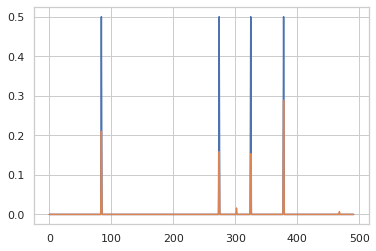

In [ ]:
plt.plot(yte[:,:,13].reshape(yte.shape[1]))
plt.plot(pred[:,:,13].reshape(yte.shape[1]))